In [1]:
import numpy as np
from tifffile import imread
import caiman as cm
from caiman.motion_correction import MotionCorrect
import os
import time
import numpy as np
import h5py
import numpy.ma as ma
# from jnormcorre.motion_correction import MotionCorrect
from ScanImageTiffReader import ScanImageTiffReader
from scipy.fft import fft2
import cv2
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.cluster.hierarchy import fcluster
from scipy.ndimage import convolve, shift
from tifffile import tifffile
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numba import jit, int64, float32, prange

In [2]:
try:
    cv2.setNumThreads(0)
except:
    pass

data = imread('/root/capsule/data/iGluSnFR_simulations/298/SIMULATION_scan_00002_298_Trial1.tif') # TODO: Add logic for h5 as well

max_shifts = (22, 22)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = False  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

# start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

# Create a motion correction object
mc = MotionCorrect(data, dview=dview, max_shifts=max_shifts,
                shifts_opencv=shifts_opencv, nonneg_movie=True,
                border_nan=border_nan)

In [3]:
# Perform motion correction
mc.motion_correct(save_movie=True)
m_rig = cm.load(mc.mmap_file)

F = np.transpose(m_rig, (1, 2, 0))

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


In [4]:
def circshift(arr, shift, axes=None):
    """
    Circularly shift the elements of an array.

    Parameters:
    - arr (np.ndarray): Input array to be shifted.
    - shift (int, list, or np.ndarray): Number of places by which elements are shifted.
        - If an integer, the same shift is applied to all axes.
        - If a list or np.ndarray, each element specifies the shift for the corresponding axis.
    - axes (int, list of ints, or None, optional): Axis or axes along which to shift.
        - If None and shift is an integer, shift is applied to all axes.
        - If None and shift is a list/array, the length of shift must match the number of dimensions in arr.
        - Can be an integer or a list of integers corresponding to the axes.

    Returns:
    - np.ndarray: The shifted array.

    Raises:
    - ValueError: If the length of shift does not match the number of specified axes.
    """
    arr = np.asarray(arr)
    ndim = arr.ndim

    # Handle the axes parameter
    if axes is None:
        if isinstance(shift, (int, float)):
            axes = tuple(range(ndim))
            shift = (int(shift),) * ndim
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != ndim:
                raise ValueError("Length of shift array must match number of dimensions of arr.")
            axes = tuple(range(ndim))
    else:
        if isinstance(axes, int):
            axes = (axes,)
        elif isinstance(axes, (list, tuple, np.ndarray)):
            axes = tuple(axes)
        else:
            raise ValueError("axes must be an int or a list/tuple of ints.")

        if isinstance(shift, (int, float)):
            shift = (int(shift),) * len(axes)
        else:
            shift = tuple(int(s) for s in shift)
            if len(shift) != len(axes):
                raise ValueError("Length of shift array must match number of specified axes.")

    # Apply the shifts
    for axis, s in zip(axes, shift):
        arr = np.roll(arr, shift=s, axis=axis)

    return arr

def process_raw_frames_cpu(Ad, viewR, viewC, numChannels, nanRows, nanCols, motionC, motionR):
    num_frames = len(motionC)
    num_cores = cpu_count()
    chunk_size = num_frames // num_cores

    chunks = []
    for i in range(num_cores):
        start_frame = i * chunk_size
        end_frame = start_frame + chunk_size if i < num_cores - 1 else num_frames
        chunk_args = (Ad[:, :, :, start_frame:end_frame], viewR, viewC, numChannels, nanRows, nanCols, 
                      motionC, motionR, start_frame, end_frame)
        chunks.append(chunk_args)

    with Pool(num_cores) as pool:
        results = pool.map(process_chunk, chunks)

    tiffSave_raw = np.concatenate(results, axis=2)
    return tiffSave_raw
    
def downsampleTime(Y, ds_time):
    for _ in range(ds_time):
        Y = Y[:, :, :, :2*(Y.shape[3]//2):2] + Y[:, :, :, 1:2*(Y.shape[3]//2):2]
    return Y

def evaluate_description(desc):
    # Split the data into lines
    lines = desc.strip().split('\n')

    # Parse each line
    parsed_data = {}
    for line in lines:
        # Split the line into key and value
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        
        # Try to evaluate the value as Python literal if possible
        try:
            value = eval(value)
        except (NameError, SyntaxError):
            # If eval fails, keep the value as a string
            pass
        
        # Store in the dictionary
        parsed_data[key] = value

    return parsed_data    
    
def dftups(inp, nor, noc, usfac, roff=0, coff=0):
    nr, nc = inp.shape
    # Compute kernels and obtain DFT by matrix products
    # kernc = np.exp(
    #     (-1j * 2 * np.pi / (nc * usfac))
    #     * (np.fft.ifftshift(np.arange(nc)) - np.floor(nc/2)).reshape(-1, 1)
    #     @ (np.arange(noc) - coff).reshape(1, -1)
    # )
    # kernr = np.exp(
    #     (-1j * 2 * np.pi / (nr * usfac))
    #     * (np.arange(nor).reshape(-1, 1) - roff)
    #     @ (np.fft.ifftshift(np.arange(nr)) - np.floor(nr/2)).reshape(1, -1)
    #     )
    # Compute kernc (column kernel)
    kernc = np.exp((-1j * 2 * np.pi / (nc * usfac)) *
                (np.fft.ifftshift(np.arange(nc)) - np.floor(nc / 2)).reshape(-1, 1) *
                (np.arange(noc) - coff))

    # Compute kernr (row kernel)
    kernr = np.exp((-1j * 2 * np.pi / (nr * usfac)) *
                (np.arange(nor).reshape(-1, 1) - roff) *
                (np.fft.ifftshift(np.arange(nr)) - np.floor(nr / 2)))
    out = kernr @ inp @ kernc
    return out
    
def dftregistration_clipped(buf1ft, buf2ft, usfac=1, clip=None):
    if clip is None:
        clip = [0, 0]
    elif isinstance(clip, (int, float)):
        clip = [clip, clip]

    # Compute error for no pixel shift
    if usfac == 0:
        CCmax = np.sum(buf1ft * np.conj(buf2ft))
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        output = [error, diffphase]
        return output, None

    # Whole-pixel shift - Compute crosscorrelation by an IFFT and locate the peak
    elif usfac == 1:
        m, n = buf1ft.shape
        md2 = m // 2
        nd2 = n // 2
        CC = np.fft.ifft2(buf1ft * np.conj(buf2ft))

        keep = np.ones(CC.shape, dtype=bool)
        keep[clip[0] // 2 + 1 : -clip[0] // 2, :] = False
        keep[:, clip[1] // 2 + 1 : -clip[1] // 2] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=0)
        loc1 = np.argmax(np.real(CC), axis=0)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        rloc = loc1[loc2]
        cloc = loc2
        CCmax = CC[rloc, cloc]
        rfzero = np.sum(np.abs(buf1ft.flatten()) ** 2) / (m * n)
        rgzero = np.sum(np.abs(buf2ft.flatten()) ** 2) / (m * n)
        error = 1.0 - CCmax * np.conj(CCmax) / (rgzero * rfzero)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))

        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m - 1  # Add the -1
        else:
            row_shift = rloc - 1      # Add the -1

        if cloc > nd2:
            col_shift = cloc - n - 1  # Add the -1
        else:
            col_shift = cloc - 1      # Add the -1

        output = [error, diffphase, row_shift, col_shift]
        return output, None

    # Partial-pixel shift
    else:
        m, n = buf1ft.shape
        mlarge = m * 2
        nlarge = n * 2
        CC = np.zeros((mlarge, nlarge), dtype=np.complex128)
        # CC[
        #     m - (m // 2) : m + (m // 2),
        #     n - (n // 2) : n + (n // 2),
        # ] = np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        # Adjust slicing indices to match (41, 125)
        row_start = m - (m // 2)
        row_end = row_start + buf1ft.shape[0]  # Ensure it matches rows of buf1ft
        col_start = n - (n // 2)
        col_end = col_start + buf1ft.shape[1]  # Ensure it matches columns of buf2ft

        # Perform fftshift and element-wise multiplication with conjugate
        CC[row_start:row_end, col_start:col_end] = (
            np.fft.fftshift(buf1ft) * np.conj(np.fft.fftshift(buf2ft))
        )# Compute crosscorrelation and locate the peak
        CC = np.fft.ifft2(np.fft.ifftshift(CC))  # Calculate cross-correlation

        keep = np.ones(CC.shape, dtype=bool)
        keep[2 * clip[0] + 1 : -2 * clip[0], :] = False
        keep[:, 2 * clip[1] + 1 : -2 * clip[1]] = False
        CC[~keep] = 0

        max1 = np.max(np.real(CC), axis=0)
        loc1 = np.argmax(np.real(CC), axis=0)
        max2 = np.max(max1)
        loc2 = np.argmax(max1)
        max_val = np.max(np.real(CC))
        rloc, cloc = np.unravel_index(np.argmax(np.real(CC)), CC.shape)
        CCmax = CC[rloc, cloc]

        # Obtain shift in original pixel grid from the position of the
        # crosscorrelation peak
        m, n = CC.shape
        md2 = m // 2
        nd2 = n // 2
        if rloc > md2:
            row_shift = rloc - m
        else:
            row_shift = rloc
        if cloc > nd2:
            col_shift = cloc - n
        else:
            col_shift = cloc
        row_shift = row_shift / 2
        col_shift = col_shift / 2

        # If upsampling > 2, then refine estimate with matrix multiply DFT
        if usfac > 2:
            # Initial shift estimate in upsampled grid
            row_shift = matlab_round(row_shift * usfac) / usfac
            col_shift = matlab_round(col_shift * usfac) / usfac
            dftshift = np.fix(np.ceil(usfac * 1.5) / 2)  # Center of output array at dftshift+1
            # Matrix multiply DFT around the current shift estimate
            CC = np.conj(
                dftups(
                    buf2ft * np.conj(buf1ft),
                    np.ceil(usfac * 1.5),
                    np.ceil(usfac * 1.5),
                    usfac,
                    dftshift - row_shift * usfac,
                    dftshift - col_shift * usfac,
                )
            ) / (md2 * nd2 * usfac ** 2)
            # Locate maximum and map back to original pixel grid
            max1 = np.max(np.real(CC), axis=0) #<--------- was set to axis 0
            loc1 = np.argmax(np.real(CC), axis=0) #<--------- was set to axis 0
            max2 = np.max(max1)
            loc2 = np.argmax(max1)
            rloc = loc1[loc2]
            cloc = loc2
            CCmax = CC[rloc, cloc]
            rg00 = dftups(buf1ft * np.conj(buf1ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rf00 = dftups(buf2ft * np.conj(buf2ft), 1, 1, usfac) / (md2 * nd2 * usfac ** 2)
            rloc = rloc - dftshift
            cloc = cloc - dftshift
            row_shift = row_shift + rloc / usfac
            col_shift = col_shift + cloc / usfac

            # If upsampling = 2, no additional pixel shift refinement
        else:
            rg00 = np.sum(buf1ft * np.conj(buf1ft)) / m / n
            rf00 = np.sum(buf2ft * np.conj(buf2ft)) / m / n
        error = 1.0 - CCmax * np.conj(CCmax) / (rg00 * rf00)
        error = np.sqrt(np.abs(error))
        diffphase = np.arctan2(np.imag(CCmax), np.real(CCmax))
        # If its only one row or column the shift along that dimension has no
        # effect. We set to zero.
        if md2 == 1:
            row_shift = 0
        if nd2 == 1:
            col_shift = 0
        output = [error, diffphase, row_shift, col_shift]

        # Compute registered version of buf2ft
        if usfac > 0:
            nr, nc = buf2ft.shape
            Nr = np.fft.ifftshift(np.arange(-np.fix(nr / 2), np.ceil(nr / 2)))
            Nc = np.fft.ifftshift(np.arange(-np.fix(nc / 2), np.ceil(nc / 2)))
            Nc, Nr = np.meshgrid(Nc, Nr)
            Greg = buf2ft * np.exp(
                1j * 2 * np.pi * (-row_shift * Nr / nr - col_shift * Nc / nc)
            )
            Greg = Greg * np.exp(1j * diffphase)
        elif usfac == 0:
            Greg = buf2ft * np.exp(1j * diffphase)
        else:
            Greg = None
    return output, Greg
    
def fast_xcorr2_nans(frame, template, shiftsCenter, dShift):
    dShift = round(dShift)  # Sanity check

    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.uint8)

    # Valid pixels of the new frame
    rows, cols = template.shape
    M = np.float32([[1, 0, shiftsCenter[0]], [0, 1, shiftsCenter[1]]])
    tmp = cv2.warpAffine(1-cv2.dilate(np.isnan(template).astype(np.uint8), SE, iterations=1), M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT, flags=cv2.INTER_NEAREST).astype(bool)
    fValid = np.zeros(frame.shape, dtype=bool)
    fValid[dShift:-dShift, dShift:-dShift] = ~np.isnan(frame[dShift:-dShift, dShift:-dShift]) & tmp[dShift:-dShift, dShift:-dShift]

    tValid = np.roll(fValid, -shiftsCenter, axis=(0, 1)).astype(bool)

    F = frame[fValid]
    ssF = np.sqrt(F.dot(F))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    tV0, tV1 = np.where(tValid)
    tValidInd = tV0 * cols + tV1

    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    # Print datatypes before the loop
    for drix, shift_x in enumerate(shifts):
        for dcix, shift_y in enumerate(shifts):
            shifted_tValid = np.roll(tValid, (-shift_x, -shift_y), axis=(0, 1))
            T = template[shifted_tValid]
            ssT = np.sum(T ** 2)
            
            if ssT > 0:  # Only calculate if ssT is greater than zero
                C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
            else:
                C[drix, dcix] = np.nan  # Handle cases where ssT is zero
            
    # plt.imshow(C)
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    I = np.unravel_index(np.nanargmax(C), C.shape)
    rr, cc = I
    R = maxval / ssF  # Correlation coefficient

    if 0 < rr < len(shifts) - 1 and 0 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        motion = shiftsCenter + [shifts[rr] - dR, shifts[cc] - dC]
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + [shifts[rr], shifts[cc]]

    if np.any(np.isnan(motion)):
        raise ValueError('Motion result contains NaN values')

    return motion, R

def matlab_round(x):
    """
    Replicates MATLAB's round function behavior
    
    In MATLAB:
    - round(4.5) = 5
    - round(-4.5) = -5
    """
    if x >= 0:
        return int(np.floor(x + 0.5))
    else:
        return int(np.ceil(x - 0.5))

In [34]:
# ---------------Simulation:

import h5py
import numpy as np
from scipy.io import loadmat

# Load the MATLAB v7.3 file
file_path = '/root/capsule/scratch/Simulation_motion_bug.mat'
mat = loadmat(file_path)

maxshift = 50
sz = [45, 125, 1, 10000]

# List all variables in the file
Ad = data.transpose(1, 2, 0).reshape(45, 125, 1, -1)
F = np.transpose(m_rig, (1, 2, 0))
F = np.mean(F, axis=2)
# F = loadmat('/root/capsule/scratch/michael_template_F.mat')['F'] #TODO: Remove this

# Create a template with NaNs
template = np.full((2*maxshift + sz[0], 2*maxshift + sz[1]), np.nan)
templateFull = template

# Insert the matrix F into the template
template[maxshift:maxshift+sz[0], maxshift:maxshift+sz[1]] = F

# template = np.transpose(template)
print('template Shape----->', template.shape)
# Copy the template to T0
T0 = template.copy()

# Create T00 as a zero matrix of the same size as template
T00 = np.zeros_like(template)

nDSframes = 1250
numChannels = 1
selCh = list(range(numChannels))
clipShift = 10
initR = 0 
initC = 0

templateCt = np.zeros_like(template)
selCh = list(range(numChannels))

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

dsFac = 8
ds_time = 3

# Create view matrices for interpolation
maxshift = 50  # Define maxshift if not already defined
viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshift) - maxshift,
    np.arange(0, sz[1] + 2 * maxshift) - maxshift,
    indexing='ij'
)

template Shape-----> (145, 225)


In [35]:
import numpy as np
from scipy.fft import fft2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import spearmanr
import warnings

initR = 0 
initC = 0

# Initialize arrays to store the inferred motion and errors
motionDSr = np.nan * np.ones(nDSframes)
motionDSc = np.nan * np.ones(nDSframes)
aErrorDS = np.nan * np.ones(nDSframes)
aRankCorr = np.nan * np.ones(nDSframes)
recNegErr = np.nan * np.ones(nDSframes)

# Create view matrices for interpolation
viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshift) - maxshift,
    np.arange(0, sz[1] + 2 * maxshift) - maxshift,
    indexing='ij'
)

counter = 0
last_value = None  # Initialize to a value that won't match any valid motionDSc[DSframe] value

# Assume downsample_time, dftregistration_clipped, and xcorr2_nans are defined elsewhere
templateCt = np.zeros_like(template)
outputArray = []
xcorreArray = []
intArray = []
for DSframe in range(nDSframes):
    # if DSframe == 177:
    #     break
    
    read_start = DSframe * dsFac
    read_end = read_start + dsFac
    readFrames = np.arange(read_start, read_end)
    
    M = downsampleTime(Ad[:, :, :, readFrames], ds_time)
    M = np.sum(M[:,:,selCh,:].reshape(M.shape[0], M.shape[1], -1, M.shape[3]), axis=2).squeeze()
    
    if DSframe % 1000 == 0:
        print(f'{DSframe} of {nDSframes}')

    Ttmp = np.nanmean(np.stack((T0, T00, template), axis=2), axis=2)
    T = Ttmp[
    maxshift - initR : maxshift - initR + sz[0],
    maxshift - initC : maxshift - initC + sz[1]
    ]
    
    output,_ = dftregistration_clipped(fft2(M.astype(np.float32)), fft2(T.astype(np.float32)), 4, clipShift)
    
    outputArray.append(output) # TODO: Remove this after debug
    
    motionDSr[DSframe] = initR + output[2]
    motionDSc[DSframe] = initC + output[3]
    aErrorDS[DSframe] = output[0]
    
    if np.sqrt((motionDSr[DSframe]/sz[0])**2 + (motionDSc[DSframe]/sz[1])**2) > 0.75**2:
        x = np.arange(sz[1])
        y = np.arange(sz[0])
        mesh_x, mesh_y = np.meshgrid(x, y)
        
        start_cv2_remap = time.time()
        map_x = np.float32(viewC)
        map_y = np.float32(viewR)
        Mfull = cv2.remap(M.astype(np.float32), map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        motion, R = fast_xcorr2_nans(Mfull.astype(np.float32), Ttmp.astype(np.float32), np.array([initR, initC]), 50)
        
        xcorreArray.append(motion) # TODO: Remove this after debug
        
        motionDSr[DSframe] = motion[0]
        motionDSc[DSframe] = motion[1]
        aErrorDS[DSframe] = R
    
    if abs(motionDSr[DSframe]) < maxshift and abs(motionDSc[DSframe]) < maxshift:
        X, Y = np.meshgrid(np.arange(0, sz[1]), np.arange(0, sz[0]))
        
        Xq = viewC + motionDSc[DSframe]
        Yq = viewR + motionDSr[DSframe]
        
        A = cv2.remap(M, Xq.astype(np.float32), Yq.astype(np.float32), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        
        Asmooth = cv2.GaussianBlur(A, (0, 0), sigmaX=1)
        
        selCorr = ~np.isnan(Asmooth) & ~np.isnan(Ttmp)
        if np.sum(selCorr) > 0:
            aRankCorr[DSframe] = np.corrcoef(Asmooth[selCorr].flatten(), Ttmp[selCorr].flatten())[0, 1]
            recNegErr[DSframe] = np.mean(
                np.minimum(0, Asmooth[selCorr] * np.mean(Ttmp[selCorr]) / np.mean(Asmooth[selCorr]) - Ttmp[selCorr]
            )**2)
        
        # Sum along the third dimension, ignoring NaNs
        templateFull = np.nansum(np.stack((templateFull * templateCt, A), axis=2), axis=2)

        # Update the count where A is not NaN
        templateCt = templateCt + ~np.isnan(A)

        # Compute the average
        templateFull = templateFull / (templateCt + np.finfo(float).eps)

        # Assign to template
        template = templateFull.copy()

        # Set values to NaN where the count is less than 100
        template[templateCt < 100] = np.nan
        
        initR = matlab_round(motionDSr[DSframe]) 
        initC = matlab_round(motionDSc[DSframe])

        intArray.append([initR, initC])
    else:
        motionDSr[DSframe] = initR
        motionDSc[DSframe] = initC

0 of 1250


/tmp/ipykernel_20323/2789916336.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aErrorDS[DSframe] = output[0]


1000 of 1250


In [36]:
# **1. Time Vector Calculation (tDS)**
tDS = (np.arange(1, nDSframes + 1) * dsFac) - (2**(ds_time - 1)) + 0.5

# **2. Upsampling Points**
upsample_factor = 2 ** ds_time
desired_length = upsample_factor * nDSframes

# Use linspace to include the endpoint
upsample_points = np.linspace(1, desired_length, num=desired_length)

# **3. Interpolation for motionC**
motionC_interp = PchipInterpolator(tDS, motionDSc, extrapolate=True)
motionC = motionC_interp(upsample_points)

# **4. Interpolation for motionR**
motionR_interp = PchipInterpolator(tDS, motionDSr, extrapolate=True)
motionR = motionR_interp(upsample_points)

# **5. Nearest Interpolation for aError**
aError_interp = interp1d(
    tDS,
    aErrorDS,
    kind='nearest',
    fill_value='extrapolate'
)

aError = aError_interp(upsample_points)

maxshiftC = np.max(np.abs(motionC))
maxshiftR = np.max(np.abs(motionR))

viewR, viewC = np.meshgrid(
    np.arange(0, sz[0] + 2 * maxshiftR) - maxshiftR,
    np.arange(0, sz[1] + 2 * maxshiftC) - maxshiftC,
    indexing='ij'  # This makes meshgrid behave like MATLAB's ndgrid
)

In [37]:

file_path = '/root/capsule/data/iGluSnFR_simulations/298/SIMULATION_scan_00002_298_Trial1_groundtruth.h5'

with h5py.File(file_path, 'r') as h5_file:
    # Check if GT group exists and extract motionC and motionR from it
    if 'GT' in h5_file:
        motion_c_GT = h5_file['GT/motionC'][:] if 'motionC' in h5_file['GT'] else None
        motion_r_GT = h5_file['GT/motionR'][:] if 'motionR' in h5_file['GT'] else None

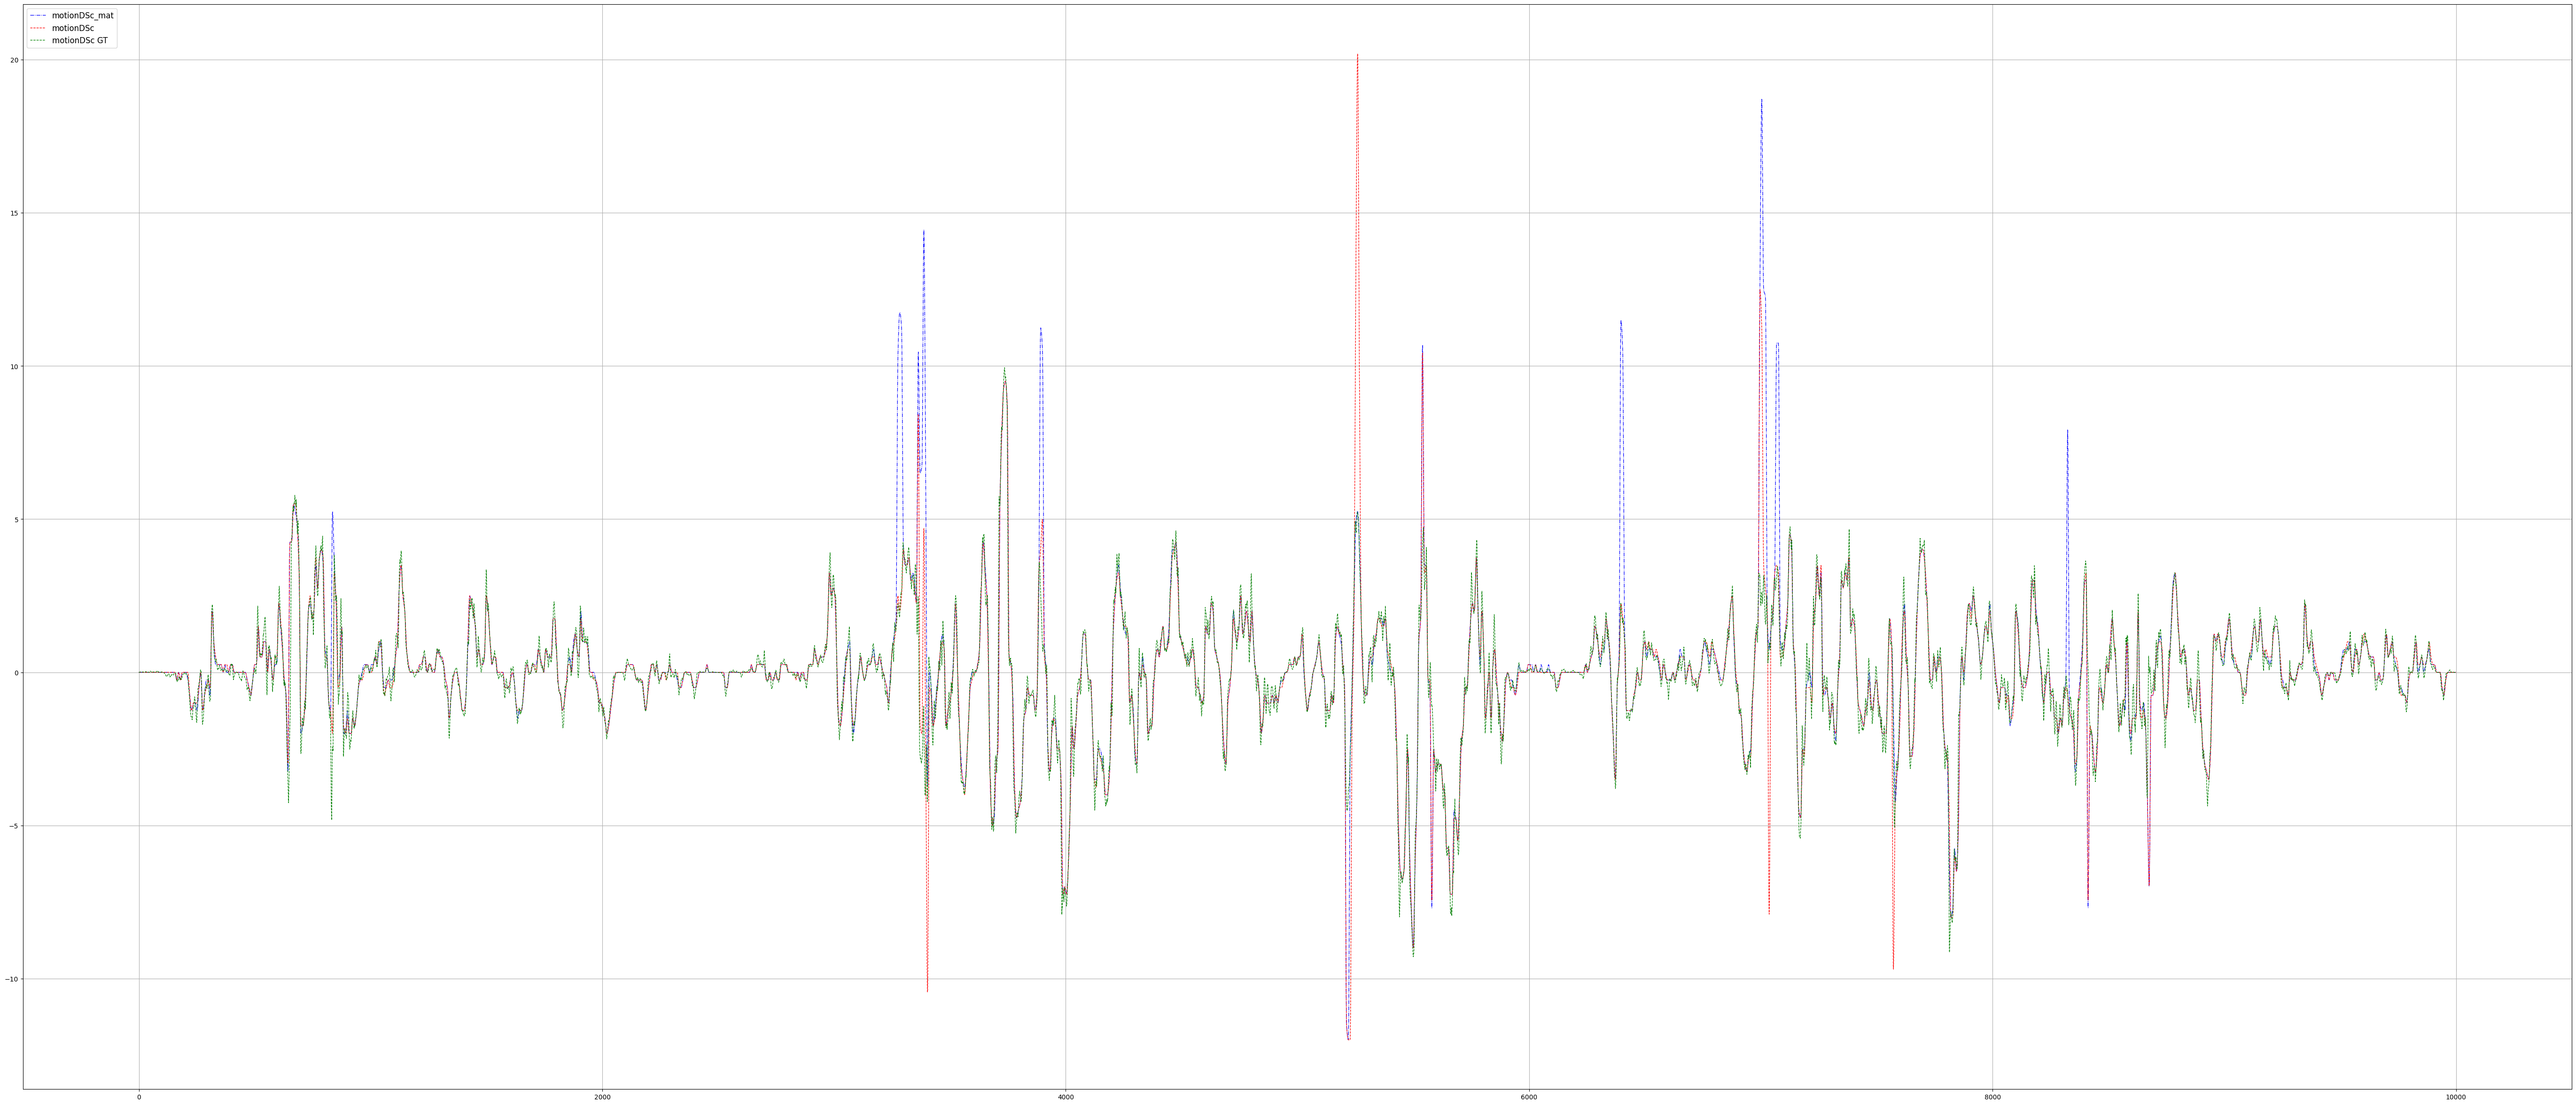

In [43]:

# Load the .mat file
mat = loadmat('/root/capsule/scratch/Motion_sim.mat')

# Extract the motionDSc data
motionDSc_mat = mat['motionC'].squeeze()

# Load the .mat file
mat = loadmat('/root/capsule/scratch/Motion_sim.mat')

# Extract the motionDSc data
motionDSr_mat = mat['motionR'].squeeze()

plt.figure(figsize=(70, 30))  # Set the figure size

# Plot the data with specified colors and line styles
plt.plot(motionDSc_mat, color='blue', label='motionDSc_mat', linestyle='dashdot', linewidth=0.9)
plt.plot(motionC, color='red', linestyle='--', label='motionDSc', linewidth=0.9)
plt.plot(motion_c_GT, color='green', linestyle='--', label='motionDSc GT', linewidth=0.9)
# Add gridlines
plt.grid(True)

# Add a legend
plt.legend(loc='upper left', fontsize='large')

# Show the plot
plt.show()

In [40]:
print('RMSE motionDSc--->', np.sqrt(np.mean((motionC - motionDSc_mat) ** 2)))
print('RMSE motionDSr--->', np.sqrt(np.mean((motionR - motionDSr_mat) ** 2)))

RMSE motionDSc---> 1.1644253971005878
RMSE motionDSr---> 0.9334741966297364


In [42]:
print('RMSE motionDSc--->', np.sqrt(np.mean((motion_c_GT - motionDSc_mat) ** 2)))
print('RMSE motionDSr--->', np.sqrt(np.mean((motion_r_GT - motionDSr_mat) ** 2)))

RMSE motionDSc---> 1.356347073839321
RMSE motionDSr---> 1.7008877664888256


In [41]:
print('RMSE motionDSc--->', np.sqrt(np.mean((motion_c_GT - motionC) ** 2)))
print('RMSE motionDSr--->', np.sqrt(np.mean((motion_r_GT - motionR) ** 2)))

RMSE motionDSc---> 0.9765716308137976
RMSE motionDSr---> 1.4399772515937537


In [45]:
# Center each dataset by subtracting its mean
motionC_centered = motionC - motionC.mean()
motionDSc_mat_centered = motionDSc_mat - motionDSc_mat.mean()
motionR_centered = motionR - motionR.mean()
motionDSr_mat_centered = motionDSr_mat - motionDSr_mat.mean()
motion_c_GT_centered = motion_c_GT - motion_c_GT.mean()
motion_r_GT_centered = motion_r_GT - motion_r_GT.mean()

# Compute RMSE on centered data
print('RMSE motionDSc PY vs Mat--->', np.sqrt(np.mean((motionC_centered - motionDSc_mat_centered) ** 2)))
print('RMSE motionDSr PY vs Mat--->', np.sqrt(np.mean((motionR_centered - motionDSr_mat_centered) ** 2)))

print('RMSE motionDSc GT vs Mat--->', np.sqrt(np.mean((motion_c_GT_centered - motionDSc_mat_centered) ** 2)))
print('RMSE motionDSr GT vs Mat--->', np.sqrt(np.mean((motion_r_GT_centered - motionDSr_mat_centered) ** 2)))

print('RMSE motionDSc GT vs PY--->', np.sqrt(np.mean((motion_c_GT_centered - motionC_centered) ** 2)))
print('RMSE motionDSr GT vs PY--->', np.sqrt(np.mean((motion_r_GT_centered - motionR_centered) ** 2)))

RMSE motionDSc PY vs Mat---> 1.1569790753805984
RMSE motionDSr PY vs Mat---> 0.9238554261356682
RMSE motionDSc GT vs Mat---> 1.3483837919661816
RMSE motionDSr GT vs Mat---> 1.6918064328575821
RMSE motionDSc GT vs PY---> 0.9764520182802824
RMSE motionDSr GT vs PY---> 1.4393684734109335
